# **UNSW-NB15 AUTOENCODER V2 RUN**

In [1]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Autoencoder training & evaluation (ready-to-run)
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score)
# reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# --- Paths ---
DATA_DIR = Path("/content/drive/MyDrive/zeusOps/data/UNSW-NB15")
MODEL_DIR = Path("/content/drive/MyDrive/zeusOps/models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# --- Load preprocessed (already scaled) data ---
x_train_df = pd.read_pickle(DATA_DIR / "unsw_x_train_v2.pkl")
x_test_df  = pd.read_pickle(DATA_DIR / "unsw_x_test_v2.pkl")
y_train_df = pd.read_pickle(DATA_DIR / "unsw_y_train_v2.pkl")
y_test_df  = pd.read_pickle(DATA_DIR / "unsw_y_test_v2.pkl")

X_train = x_train_df.values.astype("float32")
X_test  = x_test_df.values.astype("float32")
y_train_raw = np.array(y_train_df).ravel()
y_test_raw  = np.array(y_test_df).ravel()

In [4]:
# --- Detect normal label (majority class in train) and create binary labels ---
unique, counts = np.unique(y_train_raw, return_counts=True)
normal_label = unique[np.argmax(counts)]
print("Detected normal label (treated as normal):", normal_label)

y_train_binary = np.where(y_train_raw == normal_label, 0, 1)  # 0=normal,1=attack
y_test_binary  = np.where(y_test_raw  == normal_label, 0, 1)

Detected normal label (treated as normal): 7


In [5]:
# --- Prepare AE training data: only normal samples from train ---
X_train_normals = X_train[y_train_binary == 0]
print("AE training on normal-only subset shape:", X_train_normals.shape)

# --- Shuffle & split normals into AE train / AE val (explicit split) ---
rng = np.random.default_rng(SEED)
idx = np.arange(X_train_normals.shape[0])
rng.shuffle(idx)
X_shuf = X_train_normals[idx]
val_frac = 0.10
val_size = max(1, int(val_frac * X_shuf.shape[0]))
X_val = X_shuf[:val_size]
X_ae_train = X_shuf[val_size:]
print("AE train:", X_ae_train.shape, "AE val:", X_val.shape)

AE training on normal-only subset shape: (1567816, 24)
AE train: (1411035, 24) AE val: (156781, 24)


In [6]:
# --- Autoencoder architecture ---
input_dim = X_ae_train.shape[1]
encoding_dim = max(8, input_dim // 4)
ae = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(encoding_dim * 4, activation='relu'),
    layers.Dense(encoding_dim * 2, activation='relu'),
    layers.Dense(encoding_dim, activation='relu'),  # bottleneck
    layers.Dense(encoding_dim * 2, activation='relu'),
    layers.Dense(encoding_dim * 4, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])
ae.compile(optimizer='adam', loss='mse')

In [7]:
# --- Train AE (batch_size = 1024, epochs 20, early stopping) ---
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = ae.fit(
    X_ae_train, X_ae_train,
    validation_data=(X_val, X_val),
    epochs=20,
    batch_size=1024,
    callbacks=[es],
    verbose=2
)

# --- Save AE model ---
ae.save(MODEL_DIR / "unsw_autoencoder_vfinalD.h5")
print("Saved AE to:", MODEL_DIR / "unsw_autoencoder_v2.h5")

Epoch 1/20
1378/1378 - 9s - 6ms/step - loss: 0.2982 - val_loss: 0.2040
Epoch 2/20
1378/1378 - 5s - 4ms/step - loss: 0.1895 - val_loss: 0.1748
Epoch 3/20
1378/1378 - 6s - 5ms/step - loss: 0.1649 - val_loss: 0.1534
Epoch 4/20
1378/1378 - 6s - 4ms/step - loss: 0.1290 - val_loss: 0.1406
Epoch 5/20
1378/1378 - 10s - 7ms/step - loss: 0.1139 - val_loss: 0.1255
Epoch 6/20
1378/1378 - 12s - 8ms/step - loss: 0.0982 - val_loss: 0.1376
Epoch 7/20
1378/1378 - 5s - 4ms/step - loss: 0.0857 - val_loss: 0.1006
Epoch 8/20
1378/1378 - 11s - 8ms/step - loss: 0.0758 - val_loss: 0.0933
Epoch 9/20
1378/1378 - 6s - 4ms/step - loss: 0.0712 - val_loss: 0.0927
Epoch 10/20
1378/1378 - 10s - 7ms/step - loss: 0.0674 - val_loss: 0.0807
Epoch 11/20
1378/1378 - 7s - 5ms/step - loss: 0.0644 - val_loss: 0.0651
Epoch 12/20
1378/1378 - 5s - 4ms/step - loss: 0.0607 - val_loss: 0.0671
Epoch 13/20
1378/1378 - 6s - 4ms/step - loss: 0.0588 - val_loss: 0.0685
Epoch 14/20
1378/1378 - 6s - 4ms/step - loss: 0.0538 - val_loss: 0.05

Saved AE to: /content/drive/MyDrive/zeusOps/models/unsw_autoencoder_v2.h5


In [8]:
# --- Compute reconstruction MSE on val and test ---
recon_val = ae.predict(X_val)
mse_val = np.mean(np.square(X_val - recon_val), axis=1)

recon_test = ae.predict(X_test)
mse_test = np.mean(np.square(X_test - recon_test), axis=1)

4900/4900 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
12872/12872 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step


In [9]:
# --- Thresholds: percentile from validation + best-on-test (analysis only) ---
thr_percentile = float(np.percentile(mse_val, 95))
# find best threshold on test by maximizing F1 (for analysis/tuning)
thr_grid = np.linspace(mse_test.min(), mse_test.max(), 200)
best_thr = thr_grid[0]
best_f1 = -1.0
for thr in thr_grid:
    preds_thr = (mse_test >= thr).astype(int)
    f1 = f1_score(y_test_binary, preds_thr)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print(f"Threshold (95th pct on val): {thr_percentile:.6f}")
print(f"Best threshold on test (max F1): {best_thr:.6f}  (F1={best_f1:.4f})")

Threshold (95th pct on val): 0.134455
Best threshold on test (max F1): 0.000873  (F1=0.0923)


In [10]:
# --- Predictions using the two thresholds ---
y_pred_pct = (mse_test >= thr_percentile).astype(int)
y_pred_best = (mse_test >= best_thr).astype(int)

# --- Evaluation (percentile threshold) ---
print("\n--- Evaluation (percentile threshold) ---")
print("Confusion matrix:\n", confusion_matrix(y_test_binary, y_pred_pct))
print(classification_report(y_test_binary, y_pred_pct, target_names=['normal','attack']))
auc = roc_auc_score(y_test_binary, mse_test)  # mse: higher => more anomalous
print("ROC-AUC (mse):", round(auc, 4))



--- Evaluation (percentile threshold) ---
Confusion matrix:
 [[372558  19396]
 [ 15419   4510]]
              precision    recall  f1-score   support

      normal       0.96      0.95      0.96    391954
      attack       0.19      0.23      0.21     19929

    accuracy                           0.92    411883
   macro avg       0.57      0.59      0.58    411883
weighted avg       0.92      0.92      0.92    411883

ROC-AUC (mse): 0.8237


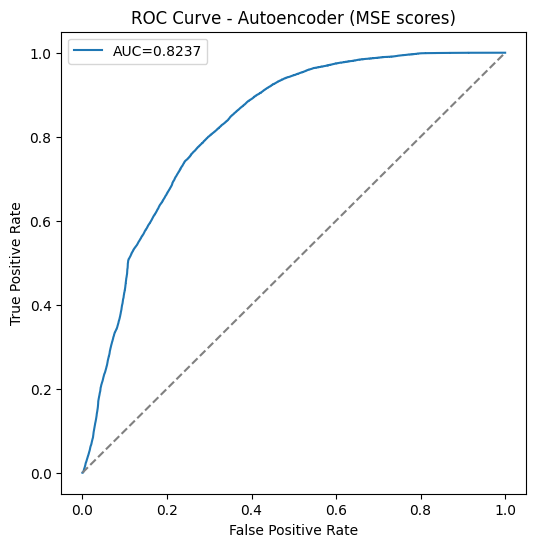

In [11]:
fpr, tpr, _ = roc_curve(y_test_binary, mse_test)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Autoencoder (MSE scores)"); plt.legend(); plt.show()

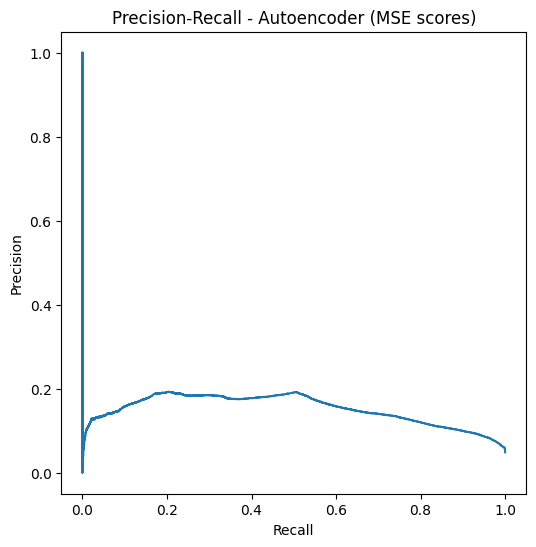

In [12]:
prec, rec, _ = precision_recall_curve(y_test_binary, mse_test)
plt.figure(figsize=(6,6))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall - Autoencoder (MSE scores)"); plt.show()


In [13]:
# --- Save test results for later ensemble/analysis ---
results_df = pd.DataFrame({
    "mse_test": mse_test,
    "y_test_binary": y_test_binary,
    "y_pred_pct": y_pred_pct,
    "y_pred_best": y_pred_best
})
results_df.to_pickle(DATA_DIR / "unsw_autoencoder_test_results_v2.pkl")
print("Saved results to:", DATA_DIR / "unsw_autoencoder_test_results_v2.pkl")

Saved results to: /content/drive/MyDrive/zeusOps/data/UNSW-NB15/unsw_autoencoder_test_results_v2.pkl


In [14]:
# --- Quick diagnostics ---
print("\nTotal test samples:", len(y_test_binary))
print("Total ground-truth attacks (1):", int(y_test_binary.sum()))
print("Predicted attacks (percentile thr):", int(y_pred_pct.sum()))
print("Predicted attacks (best thr):", int(y_pred_best.sum()))



Total test samples: 411883
Total ground-truth attacks (1): 19929
Predicted attacks (percentile thr): 23906
Predicted attacks (best thr): 411883
